# Агент, получающий обратную связь от разметчиков через платформу TagMe

Для работы с TagMe SDK нужно установить пакет. О том, как это сделать, написано: https://tagme.sberdevices.ru/docs/sdk/installation.html

Сначала проверим доступ к платформе.

In [1]:
import requests
resp = requests.get("https://tagme.sberdevices.ru")
assert resp.status_code == 200

Загрузим переменные окружения. Нужно в `.env` файле прописать `TAGME_ORGANIZATION`, `TAGME_LOGIN` и `TAGME_PASSWORD`

In [2]:
import os
from dotenv import find_dotenv, load_dotenv

In [3]:
load_dotenv(find_dotenv())

True

Для работы с TagMe SDK нужно сделать конфиг, в котором указать свои учётные данные

In [4]:
crowd_config = f"""
tagme:
 stand: cloud_prom
 org: {os.environ["TAGME_ORGANIZATION"]}
 user: {os.environ["TAGME_LOGIN"]}
 password: {os.environ["TAGME_PASSWORD"]}
"""
with open("./crowd.cfg", "w") as f:
    f.write(crowd_config)

#### Инициализируем клиент

In [5]:
from crowd_sdk.tagme import TagmeClientAdvanced

client = TagmeClientAdvanced("./crowd.cfg")

Проверим, что работает GigaChat

In [6]:
from langchain_gigachat import GigaChat

In [7]:
llm = GigaChat(
    model="GigaChat-2-Max",
    verify_ssl_certs=False,
    top_p=0,
    profanity_check=False,
    timeout=600,
)

In [8]:
llm.invoke("кто ты")

AIMessage(content='Я — GigaChat, виртуальный помощник от компании Sber. Могу поддержать разговор на любую тему, решить математику, написать код, объяснить сложное простыми словами или создать интересный контент. Чем займёмся?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 13, 'completion_tokens': 44, 'total_tokens': 57, 'precached_prompt_tokens': 2}, 'model_name': 'GigaChat-2-Max:2.0.28.02', 'x_headers': {'x-request-id': 'b10dae42-4fca-442b-882b-2c390ba2a065', 'x-session-id': '13463d88-6ca7-459c-a55c-04ae7bd1de79', 'x-client-id': None}, 'finish_reason': 'stop'}, id='b10dae42-4fca-442b-882b-2c390ba2a065', usage_metadata={'output_tokens': 44, 'input_tokens': 13, 'total_tokens': 57, 'input_token_details': {'cache_read': 2}})

#### Создадим проект

In [9]:
project = await client.create_project(
    name="giga answers improved project",  # Имя вашего проекта
    description="Проект для помощи GigaChat лучше отвечать на вопросы",  # Описание вашего проекта
)
project

Project(organization_id='148cf754-1abe-42aa-a4bb-09a377de48dd', name='giga answers improved project', description='Проект для помощи GigaChat лучше отвечать на вопросы', inner_comment='', pools=[], uid='948c3c5d-f150-4898-b0a1-736128074b10', method_id='b30bbb33-467f-4e93-9ebb-24a4ba747ea0', person_id='823cf6b2-32f5-435e-b55f-a447d04a4e0d', created_date=datetime.datetime(2025, 9, 25, 15, 22, 14, 670212, tzinfo=datetime.timezone(datetime.timedelta(seconds=10800))), update_date=datetime.datetime(2025, 9, 25, 15, 22, 14, 670212, tzinfo=datetime.timezone(datetime.timedelta(seconds=10800))), running_tasks_count=None, tasks_count=None, is_archived=False, method=None, is_bookmarked=False, pipeline=None, is_pipeline_enabled=False, template_id=None, is_brief_autoupdate=False, is_forms_autoupdate=False, is_config_autoupdate=False, markers_count_plan=None)

#### Заполним инструкции для разметчиков и интерфейс проекта

In [10]:
marker_brief = """
<h3 id="-"><strong>Цель проекта</strong></h3>
<p>Оценить ответ LLM на заданный вопрос. </p>
<p><br></p>
<h3 id="-"><strong>Шаги выполнения</strong></h3>
<ol>
    <li>
        <p><strong>Прочитайте вопрос и ответ от модели</strong></p>
    </li>
    <li>
        <p><strong>
                Если ответ Вас не устраивает, напишите подробную критику, исходя из которой модель сможет исправить свой ответ в дальнейшем.
            </strong></p>
    </li>
    <li>
        <p><strong>Если ответ Вас устраивает, напишите "ок"</strong></p>
    </li>
</ol>
<ul>
</ul>
<p><br></p>

<h3 id="-"><strong>Дополнительные рекомендации</strong></h3>
<ul>

    <li>Используйте <strong>горячую клавишу 0</strong>, чтобы быстро перейти в поле ввода. </li>

</ul>
<p><br></p>
<p><strong>Спасибо за качественные комментарии!</strong></p>
"""

html = """<tm-block>
    <tm-title>{{task}}</tm-title>
    <tm-text>{{name}}</tm-text>
    <tm-input required name="text" hotkey="0"></tm-input>
</tm-block>"""

css = """"""

js = """exports.Task = class Task extends exports.Task {

};"""

example = {
  "task": "Оцените ответ модели на вопрос",
  "name": "Вопрос: кто ты \n\nОтвет: Я — GigaChat, виртуальный помощник от компании Sber. Могу поддержать разговор на любую тему, решить сложную задачу, объяснить непонятное явление или просто развлечь беседой. Чем займёмся?"
}

specification = {
  "output_schema": {},
  "input_schema": {}
}

config = {
  "type": "generation",
  "input_data_category": "text",
  "submitOnEnter": "true",
  "markupAutosave": "true"
}

In [11]:
from IPython.display import HTML
HTML(marker_brief)

In [12]:
from crowd_sdk.tagme.types import MethodData, MethodForms

forms = MethodForms(
    html=html,
    css=css,
    js=js,
    example=example,
    specification=specification,
    config=config,
)

method = MethodData(
    uid=project.method_id,
    name="Название методики",
    forms=forms,
    marker_brief=marker_brief,
)

In [13]:
await client.update_method(method=method)

MethodData(uid='b30bbb33-467f-4e93-9ebb-24a4ba747ea0', name='Название методики', forms=MethodForms(example={'task': 'Оцените ответ модели на вопрос', 'name': 'Вопрос: кто ты \n\nОтвет: Я — GigaChat, виртуальный помощник от компании Sber. Могу поддержать разговор на любую тему, решить сложную задачу, объяснить непонятное явление или просто развлечь беседой. Чем займёмся?'}, config={'type': 'generation', 'input_data_category': 'text', 'submitOnEnter': 'true', 'markupAutosave': 'true'}, specification={'output_schema': {}, 'input_schema': {}}, html='<tm-block>\n    <tm-title>{{task}}</tm-title>\n    <tm-text>{{name}}</tm-text>\n    <tm-input required name="text" hotkey="0"></tm-input>\n</tm-block>', css='', js='exports.Task = class Task extends exports.Task {\n\n};'), marker_brief='/files/900a9101-2462-444b-bb33-fffad363fe73', organization_id='148cf754-1abe-42aa-a4bb-09a377de48dd', person_id='823cf6b2-32f5-435e-b55f-a447d04a4e0d', modification_date='2025-09-25T12:22:17.146606+00:00', is_br

#### Назначим себя разметчиком на проект

Для этого узнаем, свой uid и создадим группу разметчиков с собой

In [14]:
self_person = await client.get_self_person()
markers = [self_person.uid]
pool = await client.create_pool(
    markers=markers,
    name="группа имени меня",
)

In [15]:
await client.add_users_to_project(project_id=project.uid, pool_id=pool.uid)

In [16]:
from IPython.display import Markdown as md

project_link = await client.gen_project_url(project.uid, project.organization_id)
project_link

'https://tagme.sberdevices.ru/company/148cf754-1abe-42aa-a4bb-09a377de48dd/project/948c3c5d-f150-4898-b0a1-736128074b10'

## Сам агент

In [17]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing_extensions import TypedDict, Literal
from langgraph.checkpoint.memory import InMemorySaver
import asyncio

from crowd_sdk.tagme.types import TaskDataRequest, TaskType
from crowd_sdk.tagme.http_client.datacls import TaskData
from datetime import datetime

from rich import print as rprint

Сделаем объект состояния 

In [18]:
class State(TypedDict):
    question: str  # запрос к llm
    answer: str  # ответ от llm
    task: TaskData  # задача на разметчиков
    critique: str  # критика от разметчиков
    needs_rewrite: bool  # флаг, отвечающий за то, нужно ли переписывать ответ

Нода, в которой LLM генерирует ответ на вопрос пользователя

In [19]:
def write_answer(state: State) -> State:
    rprint("✍️ llm пишет ответ на вопрос")
    answer = llm.invoke(state.get("question")).content
    return {
        "answer": answer
    }

Далее сделаем задачу на разметчиков, в которой они будут оценивать ответ и писать критику.
Для того, чтобы названия новых задач были уникальны, добавляем к названиям текущее время.
С помощью `TaskDataRequest` создаём запрос, а с помощью метода `create_task` создаем задачу. 

Далее нужно заполнить задачу данными. Будем брать данные из состояния графа. Поля называются `task` и `name`, потому что так мы их назвали, когда составляли интерфейс для разметки.
С помощью метода `upload_json_data` добавим данные в задачу.

И затем с помощью метода `start_task` запустим задачу.

In [20]:
async def create_tagme_task(state: State) -> State:
    rprint("📝 создаем задачу для разметчиков")
    timestamp_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    create_task_request = TaskDataRequest(
        project_id=project.uid,
        organization_id=project.organization_id,
        name=f"test-task-{timestamp_str}",
        overlap=1,  # перекрытие - сколько разметчиков должны ответить
        type=TaskType.PROD, # or TaskType.STUDY | TaskType.EXAM
        description="Описание задачи",
    )

    task = await client.create_task(create_task_request)

    data = [{
        "task":
        {
          "task": "Оцените ответ модели на вопрос",
          "name": f"Вопрос: {state.get("question")}\n\nОтвет:{state.get("answer")}"
        }
    }
    ]

    await client.upload_json_data(task.uid, data)

    rprint("📂 загрузили данные для разметки в задачу")
    # запускаем задачу
    await client.start_task(task.uid)

    return {
        "task": task,
    }

В следующей ноде мы ждём, пока задача будет размечена, проверяем каждые 10 секунд не разметили ли еще нашу задачу. Как только получаем разметку, обновляем состояние, записывая туда критику и флаг - нужно ли переписывать ответ. 

Изменение `needs_rewrite` сейчас реализовано просто: если разметчик написал "ок", то переписывать ответ не требуется, а в любом другом случае требуется. Но в дальнейших доработках можно реализовать здесь более сложную логику.

In [21]:
async def wait_for_annotation(state: State):
    df = None
    rprint("👀 старт ожидания разметки")
    while df is None or df.empty:
        df = await client.get_task_assignments_df(state.get("task").uid)
        rprint("⏳ пока разметка следующая", df)
        if df is None or df.empty:
            await asyncio.sleep(10)
    rprint("✨закончили разметку")

    answer = df.iloc[0]["OUTPUT:text"]
    rprint("🤔 критика:", answer)

    needs_rewrite = answer != "ок"

    return {
        "critique": answer,
        "needs_rewrite": needs_rewrite,
    }


В следующей ноде в зависимости от значения `needs_rewrite` переходим либо заново в ноду с получением ответа на обновленный вопрос, либо завершаем работу. 

In [22]:
def review_result(state: State) -> Command[Literal["write_answer", END]]:
    rprint("🔍 агент смотрит, что делать дальше")
    if state.get("needs_rewrite", False):
        question = "Перепиши текст с учетом критики. Текст: " + state.get("answer") + " Критика: " + state.get("critique")
        updated = {"question": question}
        rprint("⚙️ нужно переписать ответ по инструкции", question)
        return Command(goto="write_answer", update=updated)
    else:
        rprint("🏁 агент закончил выполнение")
        return Command(goto=END, update=state)

Добавим checkpointer

In [23]:
checkpointer = InMemorySaver()

Соберем граф

In [25]:
graph = (
    StateGraph(State)
    .add_node("write_answer", write_answer)
    .add_node("create_tagme_task", create_tagme_task)
    .add_node("wait_for_annotation", wait_for_annotation)
    .add_node("review_result", review_result)
    .add_edge(START, "write_answer")
    .add_edge("write_answer", "create_tagme_task")
    .add_edge("create_tagme_task", "wait_for_annotation")
    .add_edge("wait_for_annotation", "review_result")
    .compile(checkpointer=checkpointer)
)
# graph

![](output.png)

Запустим агента.

Здесь будут выводиться логи.

В момент, когда агент уже поставит задачу и будет ждать разметки, необходимо будет из интерфейса разметчика https://tagme.sberdevices.ru/marker/tasks?size=10&page=1 разметить появившуюся задачу 

<!-- 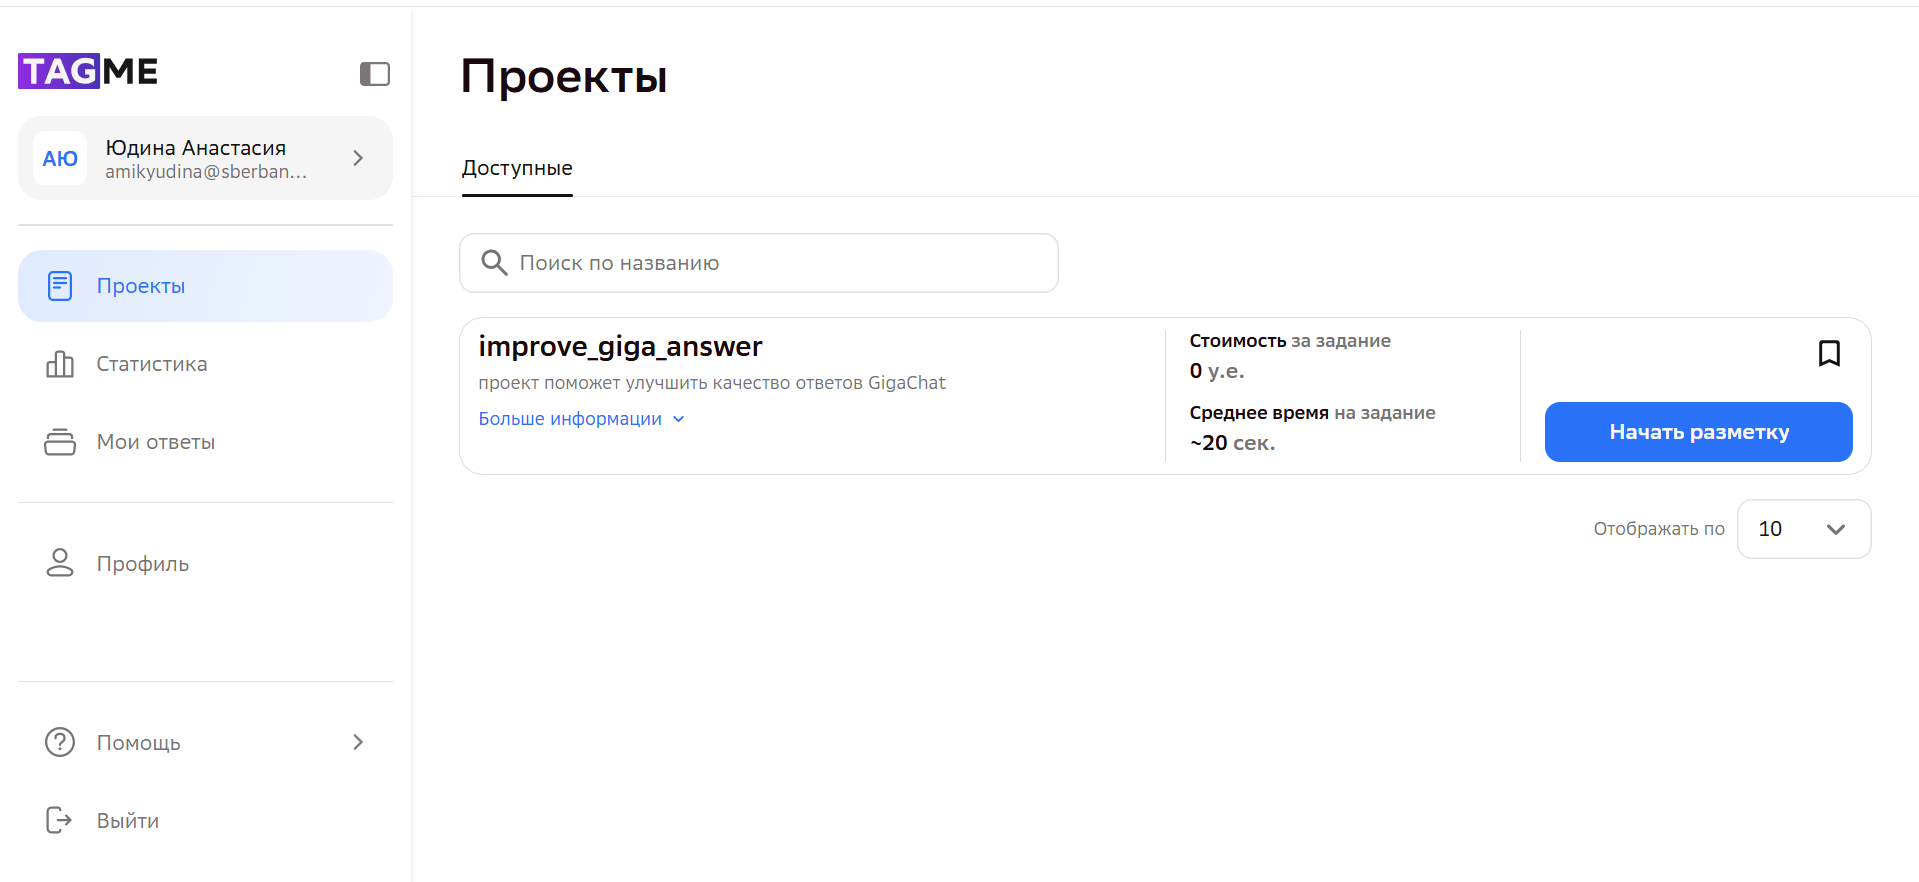 -->
Заходим с аккаунта разметчика, выбираем нужную задачу
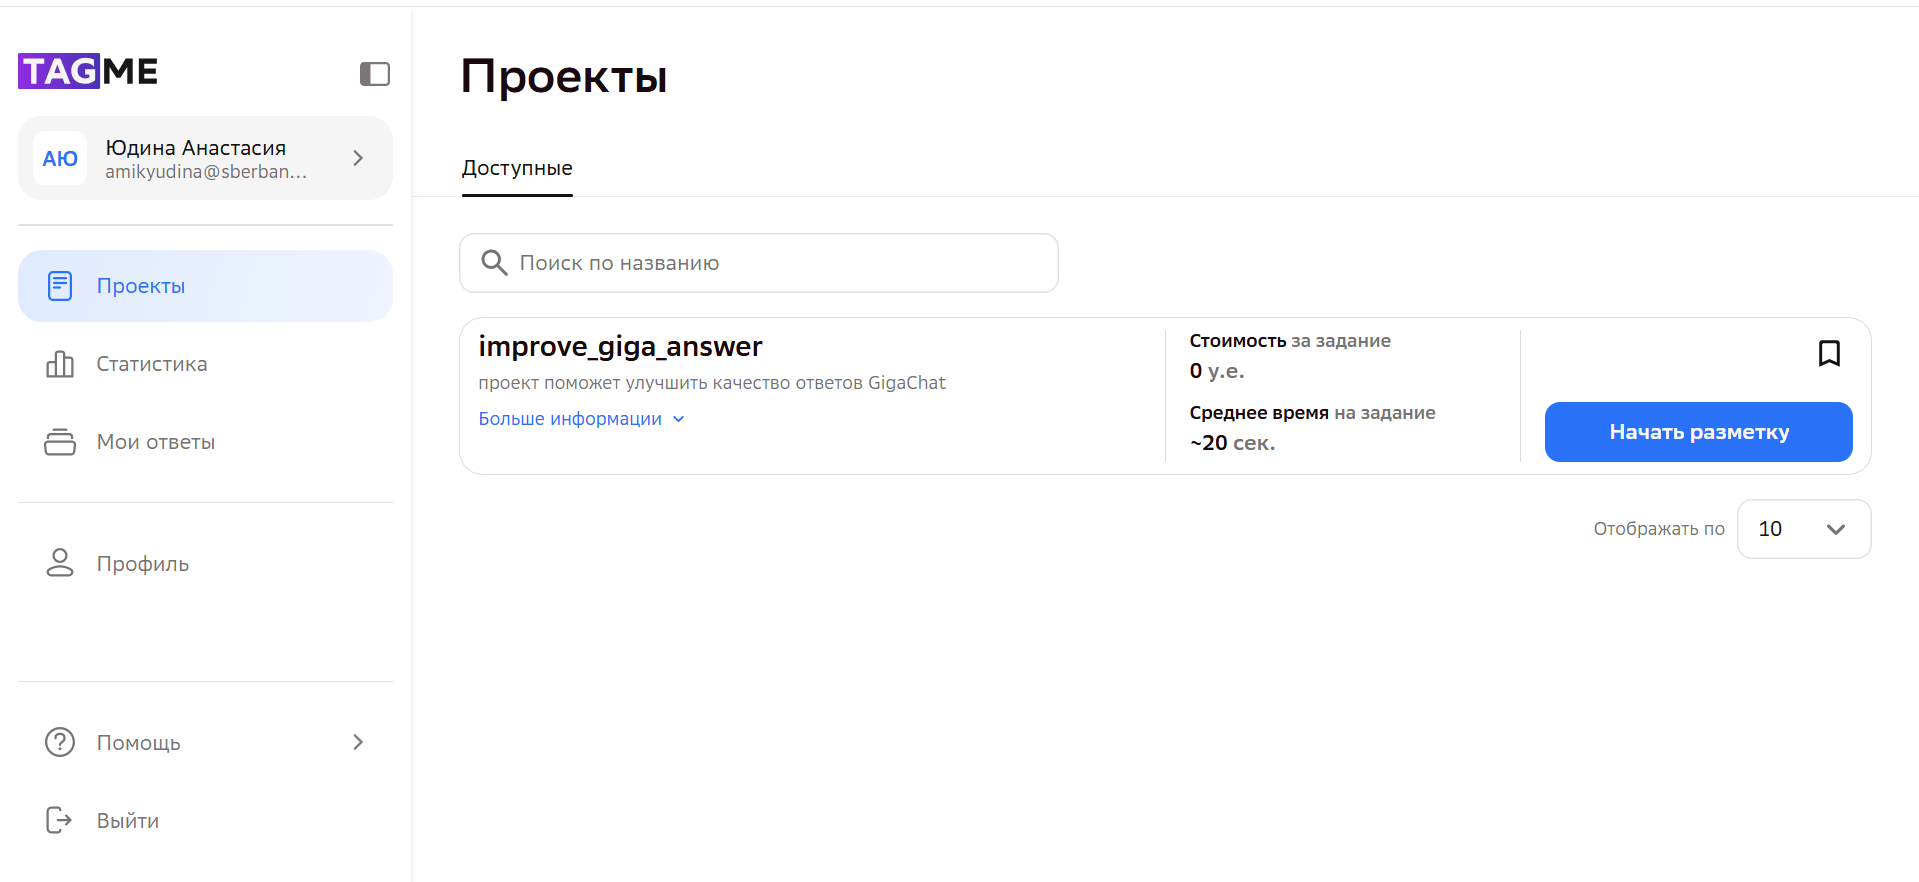

Видим, что у нас открылся исходный вопрос и ответ модели
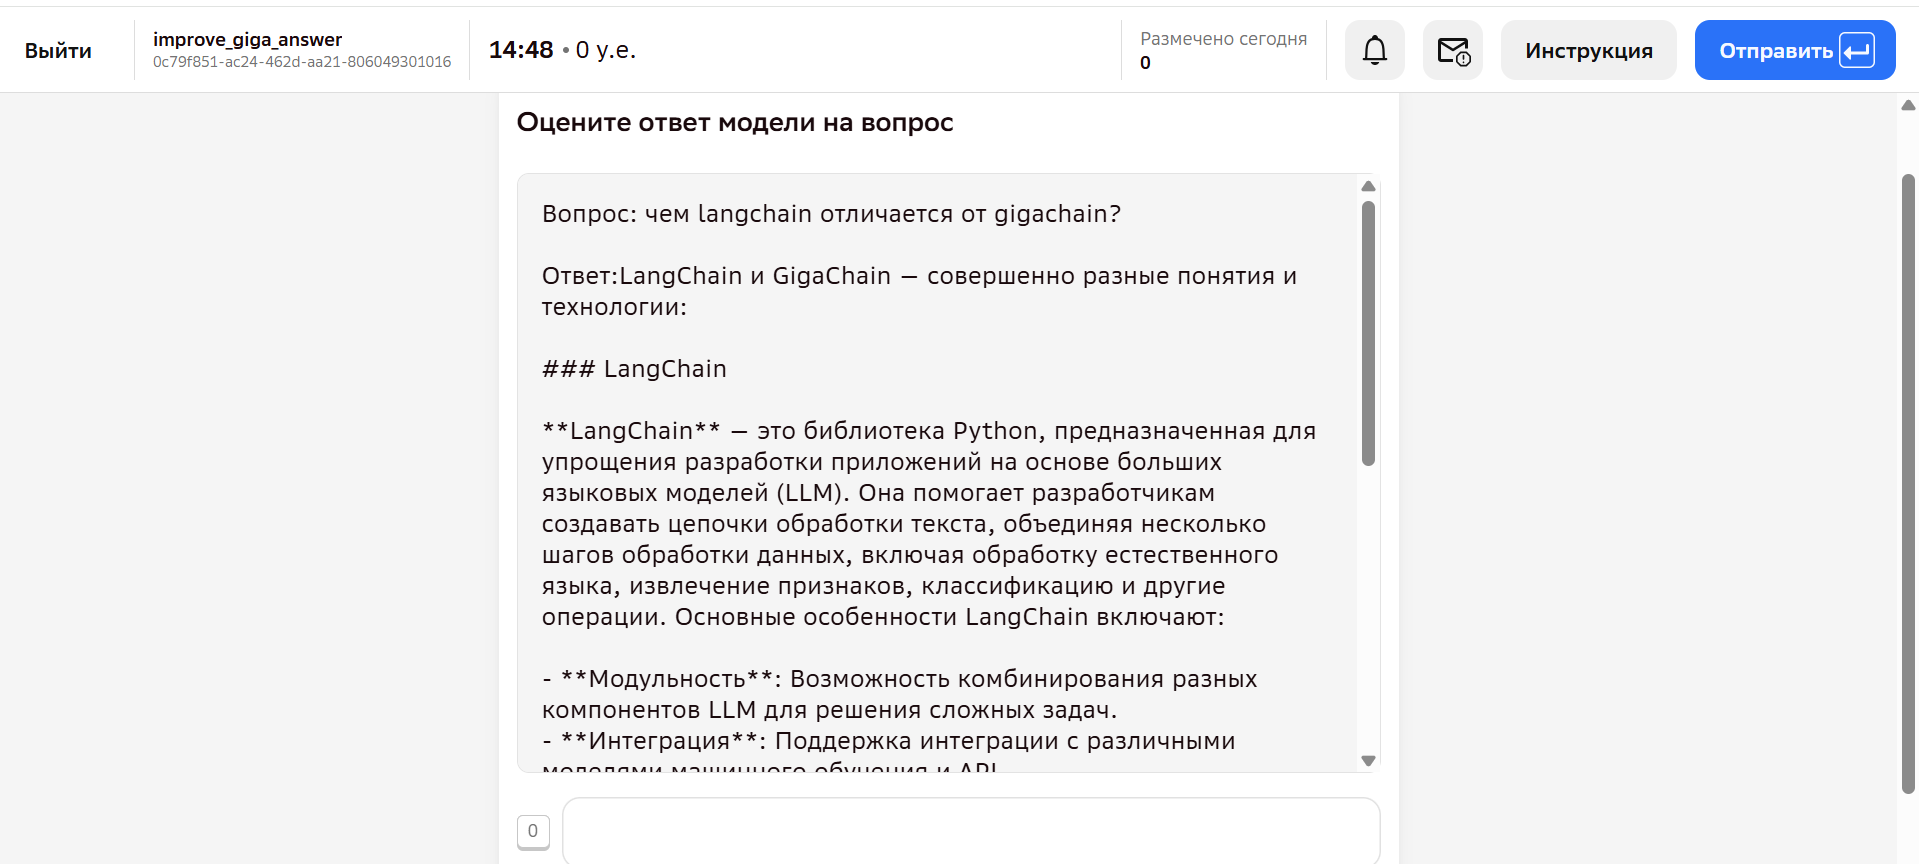

Модель ничего не знает про GigaChain, такой ответ нас не устраивает, распишем ей, что такое GigaChain. Информация взята с гитхаба.
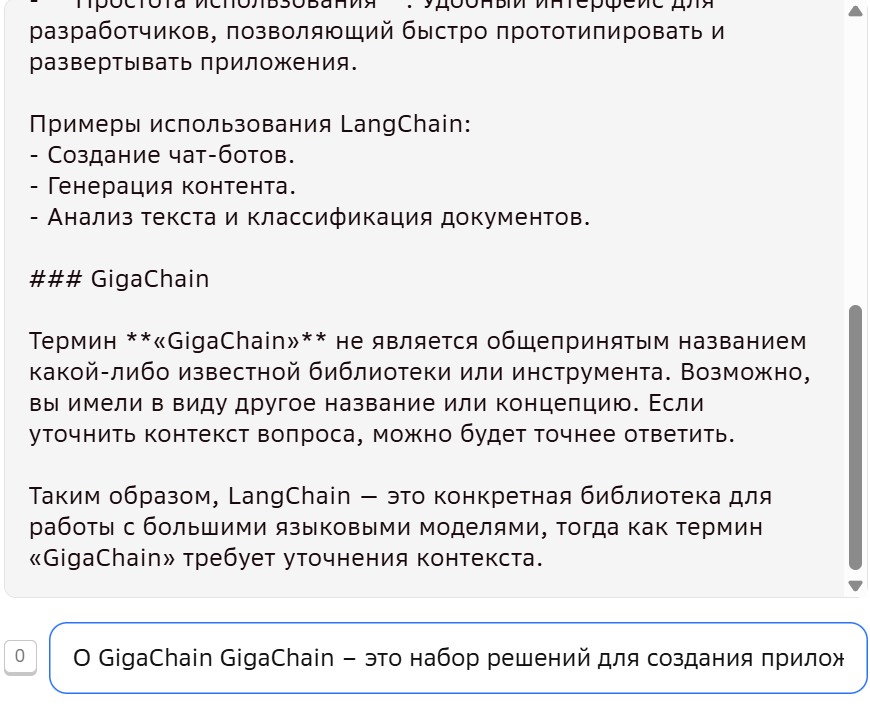

Отправляем разметку и задача выполнена
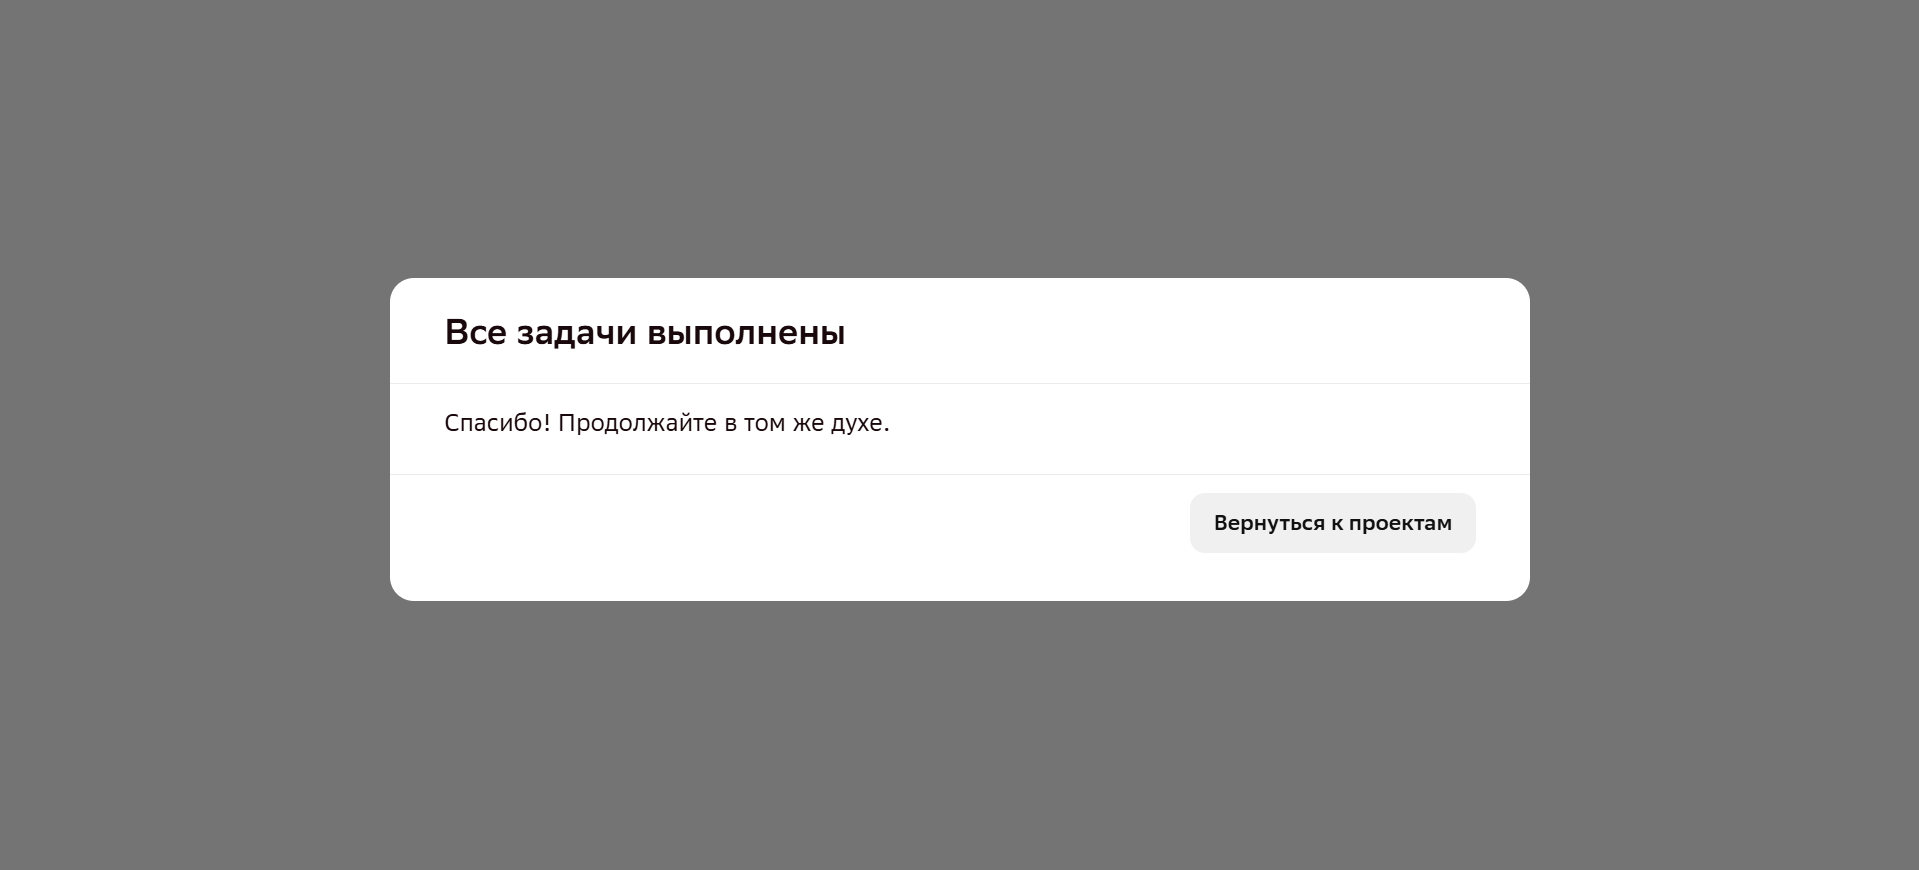

После того, как агент переписал ответ, у нас должна появиться новая задача на разметку
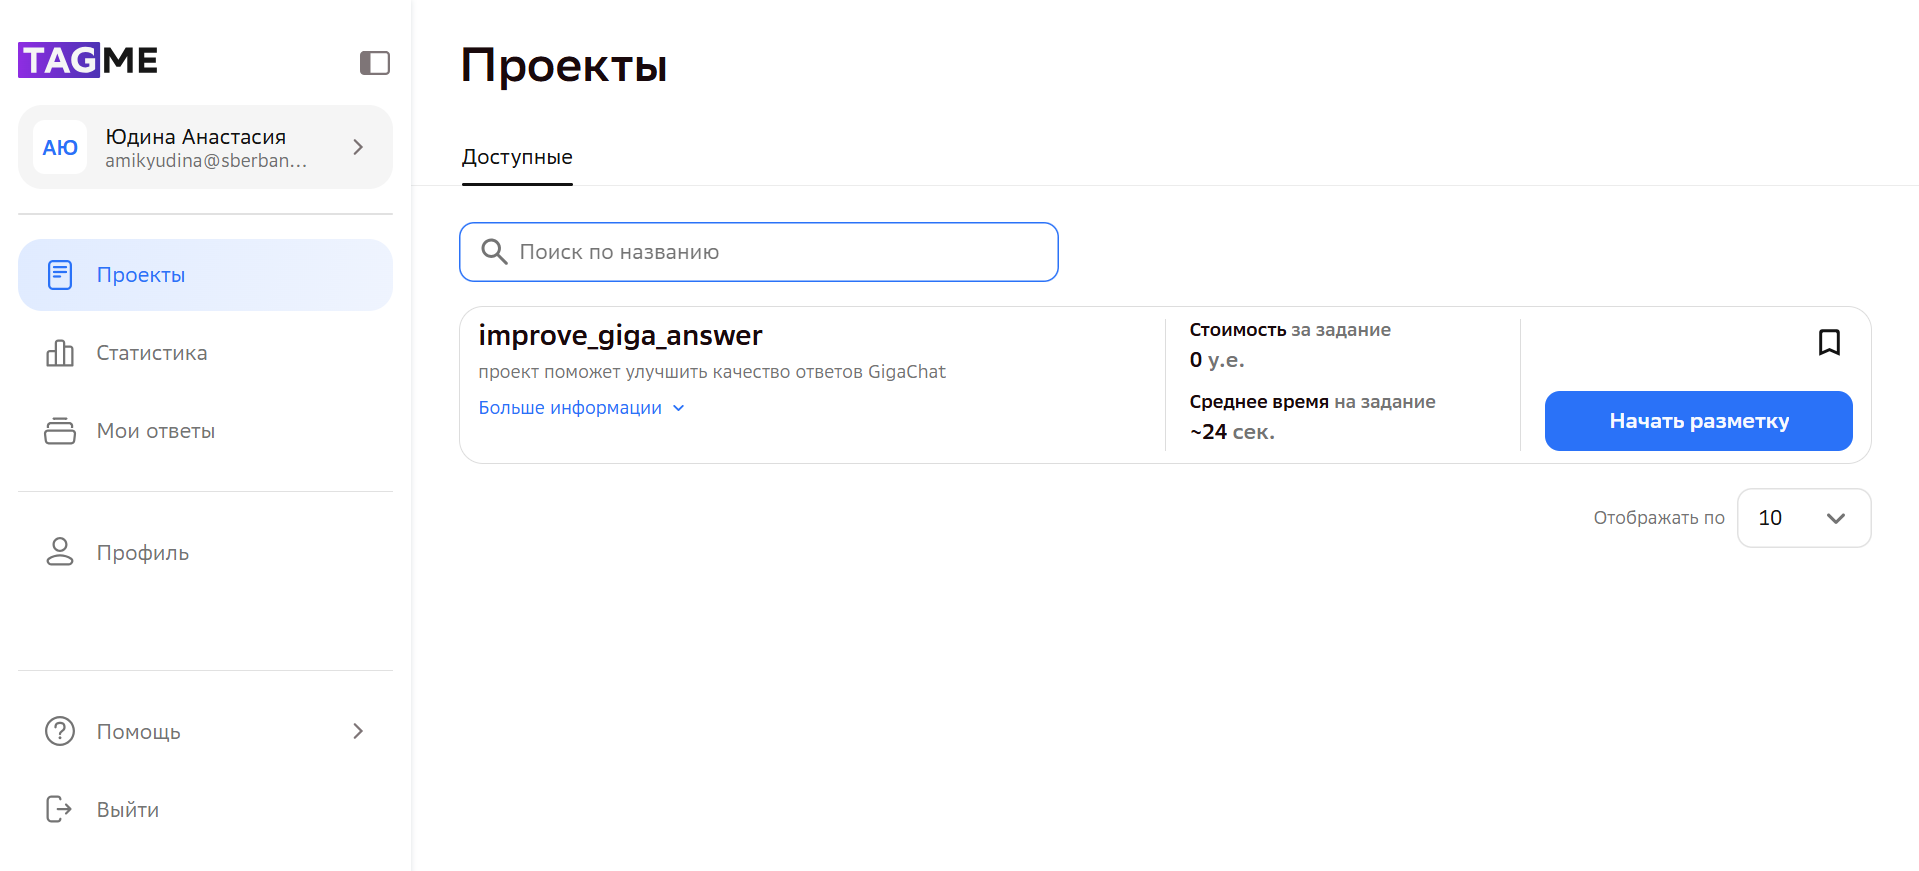

Видим, что вопрос обновился, теперь LLM отвечает на вопрос с тем, чтобы переписать текст с учётом критики 
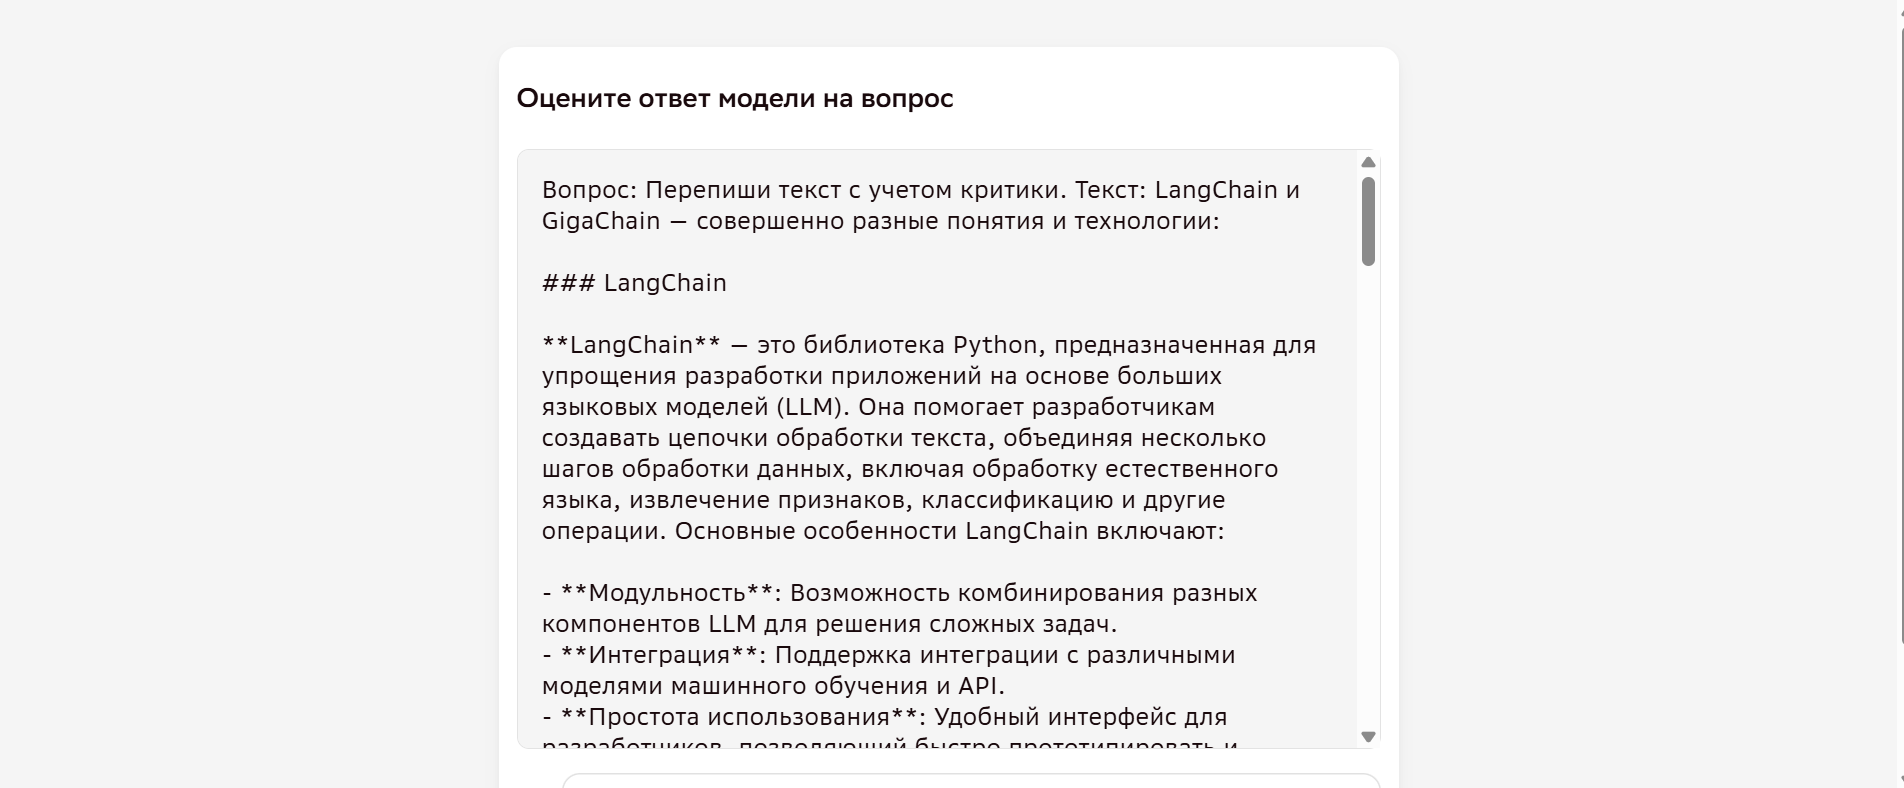

Видим, что на этот раз агент рассказал информацию о GigaChain, предположим, что нас ответ устаривает, тогда пишем "ок", чтобы агент завершил работу
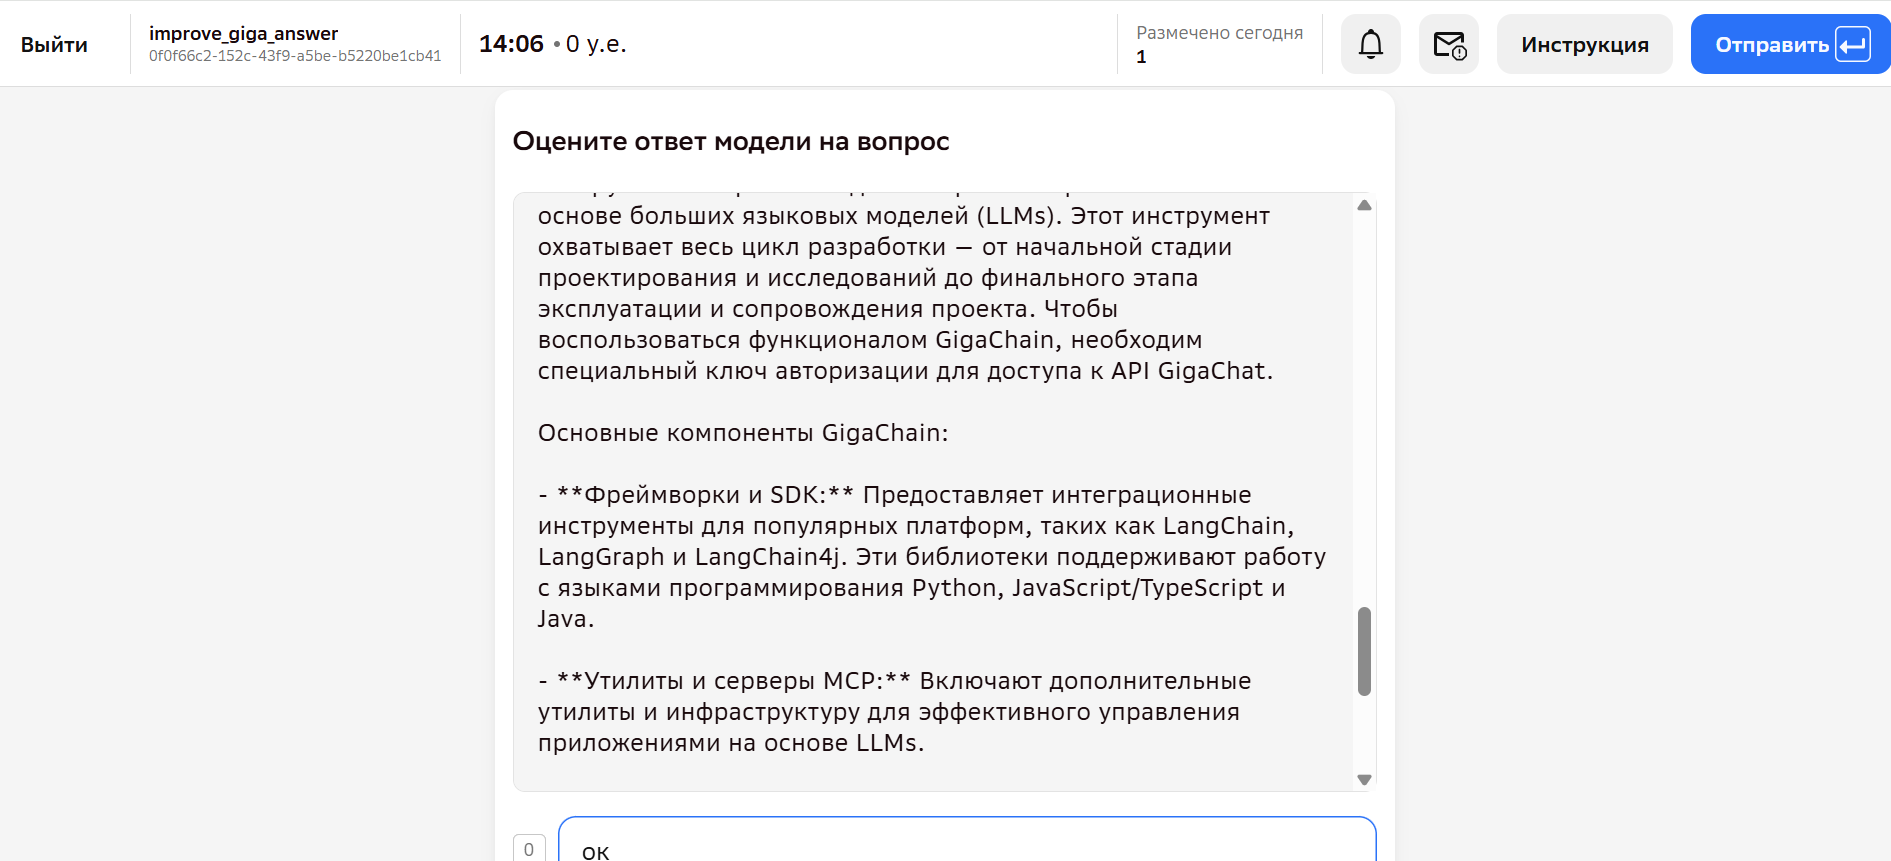

In [26]:
config = {
    "configurable": {
        "thread_id": "some_thread"
    }
}
inputs = {"question": "чем langchain отличается от gigachain?"}
result = await graph.ainvoke(inputs, config=config)

✍️ llm пишет ответ на вопрос

📝 создаем задачу для разметчиков

📂 загрузили данные для разметки в задачу

👀 старт ожидания разметки

⏳ пока разметка следующая Empty DataFrame
Columns: []
Index: []

⏳ пока разметка следующая Empty DataFrame
Columns: []
Index: []

⏳ пока разметка следующая Empty DataFrame
Columns: []
Index: []

⏳ пока разметка следующая Empty DataFrame
Columns: []
Index: []

⏳ пока разметка следующая                                          OUTPUT:text  \
0  О GigaChain GigaChain – это набор решений для ...   

                 accepted_at                         assignment_id  \
0 2025-09-25 15:23:18.114830  66fec117-a1af-448f-8c54-ddf01a829f43   

   consistency  enabled                   end_date    file_name  \
0          1.0     True 2025-09-25 15:23:18.114830  task_0.json   

   is_review_public                               item_id item_type  \
0             False  335467fe-65ca-4909-9120-b5aa979d6134      data   

                              marker_id                       organization_id  \
0  823cf6b2-32f5-435e-b55f-a447d04a4e0d  148cf754-1abe-42aa-a4bb-09a377de48dd   

                              person_id  price                 start_date  \
0  823cf6b2-32f5-435e-b55f-a447d04a4e0d    0.0 2025-09-25 15:22:54.560699   

     status               submitted_at                               task_id  
0  ACCEPTED 2025-09-25 15:23:18.114830  a3bf868f-9bcf-4a87-8c91-2cbdf7fbc28d

✨закончили разметку

🤔 критика: О GigaChain GigaChain – это набор решений для создания приложений с использованием больших языковых 
моделей (LLM). GigaChain охватывает все этапы разработки от прототипирования и исследования, до запуска в 
эксплуатацию и поддержки.  Для работы вам понадобится ключ авторизации для доступа к GigaChat API.  Наши решения: 
Фреймворки | SDK для работы с моделями GigaChat | Агенты | Утилиты и MCP-сервера  Фреймворки В состав GigaChain 
входят библиотеки для интеграции с популярными фреймворками LangChain, LangGraph и LangChain4j.  Библиотеки 
доступны на Python, JavaScript/TypeScript и Java.  Они позволяют использовать модели GigaChat со всеми 
возможностями и инфраструктурой, которую предоставляют фреймворки для разработки комплексных LLM-приложений, 
AI-агентов и мультиагентных систем.

🔍 агент смотрит, что делать дальше

⚙️ нужно переписать ответ по инструкции Перепиши текст с учетом критики. Текст: LangChain и GigaChain — совершенно 
разные понятия, хотя оба связаны с технологиями обработки данных и машинного обучения.

### LangChain

**LangChain** — это библиотека Python, предназначенная для упрощения работы с большими языковыми моделями (LLM). 
Она позволяет разработчикам создавать цепочки запросов (chains), объединяя несколько шагов обработки текста, 
включая предварительную обработку, взаимодействие с LLM и постобработку результатов. Основные функции LangChain 
включают:

- Создание последовательностей операций над текстом.
- Интеграция с различными языково-моделирующими сервисами (например, OpenAI).
- Автоматизация процессов подготовки данных и анализа результатов.

Таким образом, **LangChain** является инструментом разработки программного обеспечения, облегчающим работу с 
крупными языковыми моделями.

### GigaChain

Термин **«GigaChain»** не имеет общепринятого значения в контексте технологий ИИ или больших языковых моделей. 
Возможно, вы имели в виду другое понятие или продукт. Если уточнить контекст вопроса, можно будет точнее ответить.

---

Подведём итог:

- **LangChain**: инструмент для разработчиков, позволяющий эффективно взаимодействовать с большими языковыми 
моделями через создание цепочек обработки данных.
- **GigaChain**: термин неясного происхождения, возможно, ошибка или опечатка. Уточните, если речь идёт о чём-то 
другом. Критика: О GigaChain GigaChain – это набор решений для создания приложений с использованием больших 
языковых моделей (LLM). GigaChain охватывает все этапы разработки от прототипирования и исследования, до запуска в 
эксплуатацию и поддержки.  Для работы вам понадобится ключ авторизации для доступа к GigaChat API.  Наши решения: 
Фреймворки | SDK для работы с моделями GigaChat | Агенты | Утилиты и MCP-сервера  Фреймворки В состав GigaChain 
входят библиотеки для интеграции с популярными фреймворками LangChain, LangGraph и LangChain4j.  Библиотеки 
доступны на Python, JavaScript/TypeScript и Java.  Они позволяют использовать модели GigaChat со всеми 
возможностями и инфраструктурой, которую предоставляют фреймворки для разработки комплексных LLM-приложений, 
AI-агентов и мультиагентных систем.

✍️ llm пишет ответ на вопрос

📝 создаем задачу для разметчиков

📂 загрузили данные для разметки в задачу

👀 старт ожидания разметки

⏳ пока разметка следующая Empty DataFrame
Columns: []
Index: []

⏳ пока разметка следующая Empty DataFrame
Columns: []
Index: []

⏳ пока разметка следующая Empty DataFrame
Columns: []
Index: []

⏳ пока разметка следующая   OUTPUT:text                accepted_at  \
0          ок 2025-09-25 15:24:02.751929   

                          assignment_id  consistency  enabled  \
0  0df0fb56-fca4-416b-bac4-aa8791934149          1.0     True   

                    end_date    file_name  is_review_public  \
0 2025-09-25 15:24:02.751929  task_0.json             False   

                                item_id item_type  \
0  7c8770ac-4fb9-4aca-8b92-a11569c84282      data   

                              marker_id                       organization_id  \
0  823cf6b2-32f5-435e-b55f-a447d04a4e0d  148cf754-1abe-42aa-a4bb-09a377de48dd   

                              person_id  price                 start_date  \
0  823cf6b2-32f5-435e-b55f-a447d04a4e0d    0.0 2025-09-25 15:23:53.347438   

     status               submitted_at                               task_id  
0  ACCEPTED 2025-09-25 15:24:02.751929  796ec8e4-2aae-4cb9-803b-fa30d8727f8d

✨закончили разметку

🤔 критика: ок

🔍 агент смотрит, что делать дальше

🏁 агент закончил выполнение

In [27]:
rprint(result)

{
    'question': 'Перепиши текст с учетом критики. Текст: LangChain и GigaChain — совершенно разные понятия, хотя 
оба связаны с технологиями обработки данных и машинного обучения.\n\n### LangChain\n\n**LangChain** — это 
библиотека Python, предназначенная для упрощения работы с большими языковыми моделями (LLM). Она позволяет 
разработчикам создавать цепочки запросов (chains), объединяя несколько шагов обработки текста, включая 
предварительную обработку, взаимодействие с LLM и постобработку результатов. Основные функции LangChain 
включают:\n\n- Создание последовательностей операций над текстом.\n- Интеграция с различными языково-моделирующими 
сервисами (например, OpenAI).\n- Автоматизация процессов подготовки данных и анализа результатов.\n\nТаким образом,
**LangChain** является инструментом разработки программного обеспечения, облегчающим работу с крупными языковыми 
моделями.\n\n### GigaChain\n\nТермин **«GigaChain»** не имеет общепринятого значения в контексте технологий ИИ или 
больших языковых моделей. Возможно, вы имели в виду другое понятие или продукт. Если уточнить контекст вопроса, 
можно будет точнее ответить.\n\n---\n\nПодведём итог:\n\n- **LangChain**: инструмент для разработчиков, позволяющий
эффективно взаимодействовать с большими языковыми моделями через создание цепочек обработки данных.\n- 
**GigaChain**: термин неясного происхождения, возможно, ошибка или опечатка. Уточните, если речь идёт о чём-то 
другом. Критика: О GigaChain GigaChain – это набор решений для создания приложений с использованием больших 
языковых моделей (LLM). GigaChain охватывает все этапы разработки от прототипирования и исследования, до запуска в 
эксплуатацию и поддержки.  Для работы вам понадобится ключ авторизации для доступа к GigaChat API.  Наши решения: 
Фреймворки | SDK для работы с моделями GigaChat | Агенты | Утилиты и MCP-сервера  Фреймворки В состав GigaChain 
входят библиотеки для интеграции с популярными фреймворками LangChain, LangGraph и LangChain4j.  Библиотеки 
доступны на Python, JavaScript/TypeScript и Java.  Они позволяют использовать модели GigaChat со всеми 
возможностями и инфраструктурой, которую предоставляют фреймворки для разработки комплексных LLM-приложений, 
AI-агентов и мультиагентных систем.',
    'answer': 'Текст после переработки с учётом критики выглядит следующим образом:\n\n***\n\n## LangChain vs 
GigaChain: различия понятий\n\nХотя термины **LangChain** и **GigaChain** звучат похоже и ассоциируются с 
технологиями обработки данных и машинного обучения, они обозначают принципиально разные вещи.\n\n### 
LangChain\n\n**LangChain** — это специализированная библиотека Python, созданная для облегчения взаимодействия с 
большими языковыми моделями (Large Language Models, LLM). Её основная цель — автоматизировать процессы построения 
сложных цепочек обработки текста, включающих предобработку, запросы к LLM и последующую обработку полученных 
результатов. Ключевые возможности LangChain:\n\n- Создание многошаговых цепочек обработки данных.\n- Поддержка 
популярных сервисов моделирования языка (например, OpenAI).\n- Инструменты автоматизации подготовки данных и 
анализа результатов.\n\nТаким образом, **LangChain** представляет собой удобный инструмент для разработчиков, 
который помогает упростить интеграцию и использование крупных языковых моделей.\n\n### GigaChain\n\n**GigaChain**, 
напротив, относится к экосистеме инструментов и решений компании Sber для разработки приложений на основе больших 
языковых моделей (LLM). Это комплексное решение, охватывающее весь цикл разработки — от исследований и 
прототипирования до эксплуатации и сопровождения проектов. Среди ключевых компонентов GigaChain выделяются:\n\n- 
**Фреймворки и SDK:** интеграция с популярными библиотеками вроде LangChain, LangGraph и LangChain4j, позволяющая 
легко подключать модели GigaChat к различным платформам и языкам программирования (Python, TypeScript, Java).\n- 
**Агенты и утилиты:** инструменты для управления искусственным интелл

In [28]:
md(result["answer"])

Текст после переработки с учётом критики выглядит следующим образом:

***

## LangChain vs GigaChain: различия понятий

Хотя термины **LangChain** и **GigaChain** звучат похоже и ассоциируются с технологиями обработки данных и машинного обучения, они обозначают принципиально разные вещи.

### LangChain

**LangChain** — это специализированная библиотека Python, созданная для облегчения взаимодействия с большими языковыми моделями (Large Language Models, LLM). Её основная цель — автоматизировать процессы построения сложных цепочек обработки текста, включающих предобработку, запросы к LLM и последующую обработку полученных результатов. Ключевые возможности LangChain:

- Создание многошаговых цепочек обработки данных.
- Поддержка популярных сервисов моделирования языка (например, OpenAI).
- Инструменты автоматизации подготовки данных и анализа результатов.

Таким образом, **LangChain** представляет собой удобный инструмент для разработчиков, который помогает упростить интеграцию и использование крупных языковых моделей.

### GigaChain

**GigaChain**, напротив, относится к экосистеме инструментов и решений компании Sber для разработки приложений на основе больших языковых моделей (LLM). Это комплексное решение, охватывающее весь цикл разработки — от исследований и прототипирования до эксплуатации и сопровождения проектов. Среди ключевых компонентов GigaChain выделяются:

- **Фреймворки и SDK:** интеграция с популярными библиотеками вроде LangChain, LangGraph и LangChain4j, позволяющая легко подключать модели GigaChat к различным платформам и языкам программирования (Python, TypeScript, Java).
- **Агенты и утилиты:** инструменты для управления искусственным интеллектом и мультиагентными системами.
- **MCP-серверы:** инфраструктура для масштабируемого развертывания и обслуживания приложений на базе LLM.

Для начала работы с GigaChain необходим доступ к API GigaChat, предоставляемый по специальному ключу авторизации.

***

### Итог

- **LangChain**: библиотека Python для удобной работы с большими языковыми моделями через построение цепочек обработки данных.
- **GigaChain**: экосистема решений для полного цикла разработки приложений на основе LLM, поддерживающая разработку, запуск и поддержку проектов с помощью специализированных инструментов и инфраструктуры.